In [2]:
import scipy.io
import pandas as pd
import numpy as np
import saida
import gerarnovapop
import skfuzzy as fuzz
from scipy import sparse
import time
import matplotlib.pyplot as plt

In [3]:
# Parametros ajustaveis manualmente
nfp=5             #Funcoes de pertinencia
alfa=0.01         #Alfa - parametro de atualizacao
nepoca=5       #Numero de epocas de treinamento dos pesos para cada geração da PG

#Parametros Programacao Genetica
tamPop=100
numGeracoes=3
taxaCruza=0.7
taxaMuta=0.08
nfpMax=7; # maximo de funções de pertinência geradas em cada indivíduo

_xt_temp = np.loadtxt('xt.csv', delimiter=',', skiprows=1)
xt = _xt_temp[:, 1:] 
_yt_temp = np.loadtxt('yt.csv', delimiter=',', skiprows=1)
yt = _yt_temp[:, 1:]

# temp = np.loadtxt('AirfoilSelfNoise.csv', delimiter=',', skiprows=1)
# xt = temp[:, :-1] 
# yt = temp[:, -1]  

npt, nin = (xt).shape

nptTr = round(npt*0.6)
nptVal = round(npt*0.2)

xv = xt[nptTr-1:]
xt = xt[:nptTr]

ydv=yt[nptTr-1:]
ydt=yt[:nptTr]

npt=nptTr

xmin=xt.min(axis=0)
xmax=xt.max(axis=0)

delta=(xmax-xmin) / (nfp-1)

aux = sparse.csr_matrix(xt)

#Calculo dos parametros
p = np.empty((nin, nfp))
q = np.empty(nfp)
for i in range(nfp):
    for j in range(nin):
        p[j, i] = np.random.rand()

    q[i] = np.random.rand()
    
# #Gerar população inicial
pop = []

In [4]:

for z in range(tamPop):
    nfpSort = nfp
    cs = np.empty((nin, nfpSort))
    ss = np.empty((nin, nfpSort))
    for i in range(nfpSort):
        for j in range(nin):
            cs[j, i] = xmin[j] + np.random.rand()*(xmax[j]-xmin[j])
            ss[j, i] = np.random.rand()*(xmax[j]-xmin[j])

    individuo = {
        'nfps': nfpSort,
        'cs': cs,
        'ss': ss
    }
    individuo['saida'], _, _, _ = saida.saida(xt, individuo['cs'], individuo['ss'], p, q, individuo['nfps'])
    individuo['fitness'] = (0.5 * np.sum((individuo['saida'] - ydt)**2)) / npt
    pop.append(individuo)

    if z == 0:
        melhorindv = z
    else:
        if individuo['fitness'] < pop[melhorindv]['fitness']:
            melhorindv = z
    
c = np.array(pop[melhorindv]['cs'], dtype=float)
s = np.array(pop[melhorindv]['ss'], dtype=float)
s = pop[melhorindv]['ss']
nfp = pop[melhorindv]['nfps']
auxsize = tamPop
novapop = pop

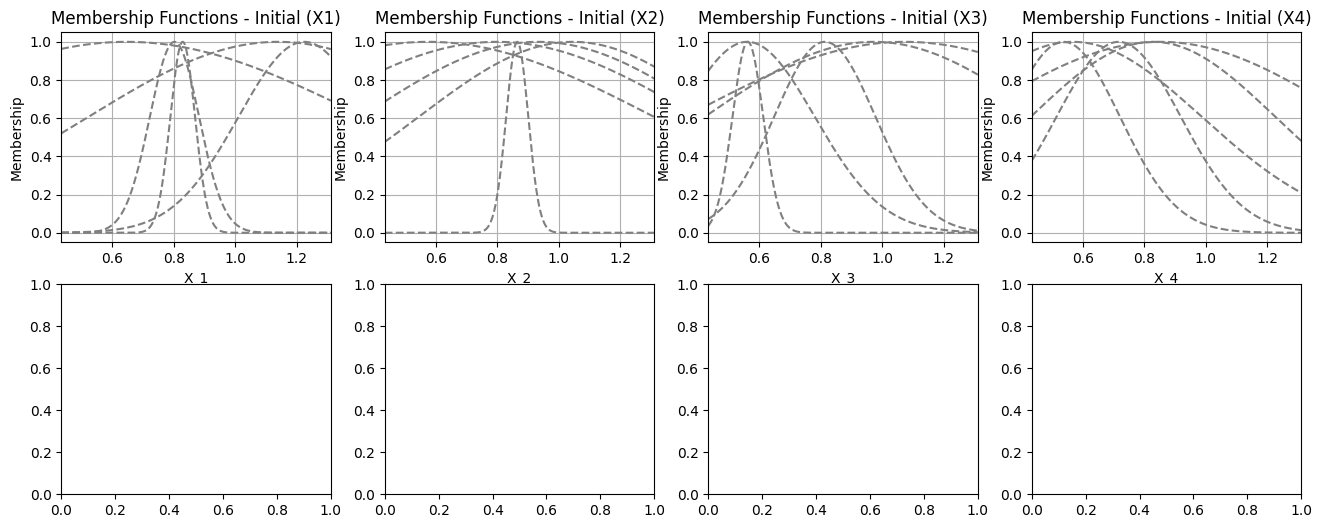

In [5]:
#Isso é do melhor indivíduo? 

fig1, axes = plt.subplots(2, nin, figsize=(4 * nin, 6))

# Membership Functions - Initial (top row)
for j in range(nfp):

    for i in range(nin):
        #Funcao de pertinencia gaussiana
        xval = np.linspace(xmin[i], xmax[i], npt)

        # xval[0] = xval[0]/10
        # xval[1] = xval[1]/10

        w_init = fuzz.gaussmf(xval, c[i, j], s[i, j])
        # print(w_init)
        ax = axes[0, i] if nin > 1 else axes
        ax.plot(xval, w_init, 'gray', linestyle='--', label='Initial' if j == 0 else "")
        ax.set_title(f'Membership Functions - Initial (X{i+1})')
        ax.set_xlabel(f'X_{i+1}')
        ax.set_ylabel('Membership')
        ax.set_xlim(xmin[i], xmax[i])
        ax.grid(True)

In [6]:
ytst, _, _, _ = saida.saida(xt,c,s,p,q,nfp)
yvst, _, _, _ = saida.saida(xv,c,s,p,q,nfp)

In [ ]:
erro = []
yst = ytst

lista_de_resultados = []
for i in range(numGeracoes):
    print('Geração ', i + 1)

    erro.append((0.5 * np.sum((yst - ydt)**2)) / npt)
    dyjdqj = 1

    for _ in range(nepoca):
        for k in range(npt):
            print(k)
            ys, w, y, b = saida.saida(xt[k, :], c, s, p, q, nfp)
            dedys = ys - ydt[k]

            for j in range(nfp):
                dysdyj = w[j] / b
                dysdwj = (y[j] - ys) / b

                for m in range(nin):
                    dyjdpj = xt[k, m]
                    # Remover /10
                    p[m, j] -= (alfa / 10.0) * dedys * dysdyj * dyjdpj

                q[j] -= (alfa / 10.0) * dedys * dysdyj * dyjdqj

    pop = gerarnovapop.gerarnovapop(pop, melhorindv, tamPop, taxaCruza, taxaMuta, xmax, xmin)

    #Avalia fitness dos indivíduos
    for z in range(tamPop):
        
        pop[z]['saida']= saida.saida(xt, pop[z]['cs'], pop[z]['ss'], p, q, pop[z]['nfps'])[0] 
        pop[z]['fitness'] = (0.5 * np.sum((pop[z]['saida'] - ydt) ** 2)) / npt
        dados_individuo = {
        'geracao': i+1,
        'individuo_id': z,
        'cs': pop[z]['cs'],
        'ss': pop[z]['ss'],
        'nfps': pop[z]['nfps'],
        'p': p,
        'q': q,
        'saida': pop[z]['saida'],
        'fitness': pop[z]['fitness']
        }

        lista_de_resultados.append(dados_individuo)

        if z == 0:
            melhorindv = z
        else:
            if pop[z]['fitness'] < pop[melhorindv]['fitness']:
                melhorindv = z

        
    c = pop[melhorindv]['cs']
    s = pop[melhorindv]['ss']
    nfp = pop[melhorindv]['nfps']
    yst = saida.saida(xt, c, s, p, q, nfp)[0]

erro.append((0.5 * np.sum((yst - ydt) ** 2)) / npt)
yst = saida.saida(xt, c, s, p, q, nfp)[0] 
ysv = saida.saida(xv, c, s, p, q, nfp)[0] 


original
[[0.25582198 0.2363161  0.68120786 0.60465808 0.56364178]
 [0.3268722  0.91758149 0.92788813 0.0191934  0.10380775]
 [0.38352659 0.56940252 0.64100426 0.72751385 0.23545917]
 [0.73043161 0.96357985 0.98702161 0.64824075 0.45805687]
 [0.36269267 0.90333812 0.5834904  0.99908907 0.9822618 ]]
[0.38922788 0.29313728 0.56897917 0.75757395 0.0051127 ]
Geração  1
inicio
[[0.25582198 0.2363161  0.68120786 0.60465808 0.56364178]
 [0.3268722  0.91758149 0.92788813 0.0191934  0.10380775]
 [0.38352659 0.56940252 0.64100426 0.72751385 0.23545917]
 [0.73043161 0.96357985 0.98702161 0.64824075 0.45805687]
 [0.36269267 0.90333812 0.5834904  0.99908907 0.9822618 ]]
[0.38922788 0.29313728 0.56897917 0.75757395 0.0051127 ]
0
[257.24444769 258.225223   616.10683798 530.92800952 483.65237229]
1
[   -234.29203544 -105438.89766275     752.11771952     651.8596252
     596.33674329]
2
[7.08461079e+05 1.30940629e+08 1.20947735e+03 8.03024145e+02
 7.92691094e+02]
3
[-1.49599253e+09 -2.59383740e+11 -5.7

C:\Users\User\AppData\Local\Temp\ipykernel_16096\3493950154.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[m, j] -= (alfa / 10.0) * dedys * dysdyj * dyjdpj
C:\Users\User\AppData\Local\Temp\ipykernel_16096\3493950154.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q[j] -= (alfa / 10.0) * dedys * dysdyj * dyjdqj
d:\ScientificIni\Scientific-Initiation\saida.py:40: RuntimeWarning: overflow encountered in scalar multiply
  y_atual[j] += p[k,j] * x[i,k]
C:\Users\User\AppData\Local\Temp\ipykernel_16096\3493950154.py:26: RuntimeWarning: invalid value encountered in subtract
  dysdwj = (y[j] - ys) / b
C:\Users\User\AppData\Local\Temp\

[nan nan nan nan nan]
809
[nan nan nan nan nan]
810
[nan nan nan nan nan]
811
[nan nan nan nan nan]
812
[nan nan nan nan nan]
813
[nan nan nan nan nan]
814
[nan nan nan nan nan]
815
[nan nan nan nan nan]
816
[nan nan nan nan nan]
817
[nan nan nan nan nan]
818
[nan nan nan nan nan]
819
[nan nan nan nan nan]
820
[nan nan nan nan nan]
821
[nan nan nan nan nan]
822
[nan nan nan nan nan]
823
[nan nan nan nan nan]
824
[nan nan nan nan nan]
825
[nan nan nan nan nan]
826
[nan nan nan nan nan]
827
[nan nan nan nan nan]
828
[nan nan nan nan nan]
829
[nan nan nan nan nan]
830
[nan nan nan nan nan]
831
[nan nan nan nan nan]
832
[nan nan nan nan nan]
833
[nan nan nan nan nan]
834
[nan nan nan nan nan]
835
[nan nan nan nan nan]
836
[nan nan nan nan nan]
837
[nan nan nan nan nan]
838
[nan nan nan nan nan]
839
[nan nan nan nan nan]
840
[nan nan nan nan nan]
841
[nan nan nan nan nan]
842
[nan nan nan nan nan]
843
[nan nan nan nan nan]
844
[nan nan nan nan nan]
845
[nan nan nan nan nan]
846
[nan nan nan

In [ ]:


fig1, axes = plt.subplots(2, nin, figsize=(4 * nin, 6))
for j in range(nfp):
    for i in range(nin):
        w = fuzz.gaussmf(xval, c[i, j], s[i, j])
        ax = axes[1, i] if nin > 1 else axes
        ax.plot(xval, w, 'k')
        ax.set_title('Membership Functions - Final')
        ax.set_xlabel(f'X_{i+1}')
        ax.set_ylabel('Membership')
        ax.set_xlim(xmin[i], xmax[i])
        ax.grid(True)

fig1.tight_layout()

# ---------- 2. Training Error (MSE) ----------
fig2 = plt.figure()
plt.plot(erro, 'r', linewidth=1.5)
plt.xlabel('Geração')
plt.ylabel('EQM')
plt.title('Erro Quadrático Médio')
plt.grid(True)

# ---------- 3. Training and Validation Outputs ----------
fig3, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].plot(ydt, 'r', label='Saída Desejada')
axs[0, 0].plot(ytst, 'k', label='Saída Inicial')
axs[0, 0].set_title('Treinamento - Saída Desejada x Saída Inicial')
axs[0, 0].set_xlabel('Pontos')
axs[0, 0].set_ylabel('X')
axs[0, 0].legend()

axs[0, 1].plot(yst, 'g')
axs[0, 1].set_title('Treinamento - Saída Final')
axs[0, 1].set_xlabel('Pontos')
axs[0, 1].set_ylabel('X')

axs[0, 2].plot(ydt, 'r', label='Saída Desejada')
axs[0, 2].plot(yst, 'g', label='Saída Final')
axs[0, 2].set_title('Treinamento - Saída Desejada x Saída Final')
axs[0, 2].set_xlabel('Pontos')
axs[0, 2].set_ylabel('Y')
axs[0, 2].legend()

axs[1, 0].plot(ydv, 'r', label='Saída Desejada')
axs[1, 0].plot(yvst, 'k', label='Saída Inicial')
axs[1, 0].set_title('Validação - Saída Desejada x Saída Inicial')
axs[1, 0].set_xlabel('Pontos')
axs[1, 0].set_ylabel('X')
axs[1, 0].legend()

axs[1, 1].plot(ysv, 'g')
axs[1, 1].set_title('Validação - Saída Final')
axs[1, 1].set_xlabel('Pontos')
axs[1, 1].set_ylabel('X')

axs[1, 2].plot(ydv, 'r', label='Saída Desejada')
axs[1, 2].plot(ysv, 'g', label='Saída Final')
axs[1, 2].set_title('Validação - Saída Desejada x Saída Final')
axs[1, 2].set_xlabel('Pontos')
axs[1, 2].set_ylabel('Y')
axs[1, 2].legend()

fig3.tight_layout()

# ---------- 4. Final Training Output ----------
fig4 = plt.figure()
plt.plot(ydt, 'r', label='Saída Desejada')
plt.plot(yst, 'b', label='Saída GP-NFN-I')
plt.xlabel('Pontos')
plt.ylabel('Y')
plt.title('Treinamento - Saída Desejada x Saída Final')
plt.legend()

# ---------- 5. Final Validation Output ----------
fig5 = plt.figure()
plt.plot(ydv, 'r', label='Desired Output')
plt.plot(ysv, 'g', label='Estimated Output')
plt.xlabel('Samples')
plt.ylabel('Y')
plt.title('Validation - Desired Output x Estimated Output')
plt.legend()

# ---------- Show All ----------
plt.show()